# **PHYS 305 Fall 2025 - Final Project**
**Title**: The Brachistochrone Problem \
**Student**: Thomas Nguyen \
**Instructors**: Dr. Vasileios Paschalidis, Devendran Vemula \
**Abstract**: (From paper)

Import required package(s) here

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline
%matplotlib inline

Default parameters for plots (Change locally if needed)

In [49]:
plt.rcParams["figure.figsize"] = (25,20) # Figure size

plt.rcParams["axes.titley"] = 1.015 # Adjust title y-position 
plt.rcParams['axes.titlesize'] = 40 # Title font size

plt.rcParams['axes.labelsize'] = 35 # Axis label font size

plt.rcParams['xtick.labelsize'] = 30 # X-tick label font size
plt.rcParams['xtick.major.size'] = 12 # X-tick major size
plt.rcParams['xtick.minor.size'] = 6 # X-tick major size
plt.rcParams['xtick.major.width'] = 2.5 # X-tick major width
plt.rcParams['xtick.minor.width'] = 2 # X-tick minor width

plt.rcParams['ytick.labelsize'] = 30 # Y-tick label font size
plt.rcParams['ytick.major.size'] = 12 # X-tick major size
plt.rcParams['ytick.minor.size'] = 6 # X-tick major size
plt.rcParams['ytick.major.width'] = 2.5 # X-tick major width
plt.rcParams['ytick.minor.width'] = 2 # X-tick minor width

plt.rcParams['legend.title_fontsize'] = 40 # Legend title font size
plt.rcParams['legend.fontsize'] = 35 # Legend font size

plt.rcParams['lines.markersize'] = 15 # Marker size
plt.rcParams['lines.linewidth'] = 4 # Line width
plt.rcParams['grid.linewidth'] = 2.0    

## **Define constant(s) and required utility function(s)**

### Define any constants here

In [50]:
g = 9.81 # Gravitational constant (m/s^2)

### Define the system of first-order ODEs

$$z''(x)=-\frac{z'^2+1}{2z}$$

Let $u_0(x)$ = $z(x)$ and $u_1(x)$ = $z'(x)$ \
Then $u_0'(x)=z'(x)=u_1(x)$ and $u_1'(x)=z''(x)=-\frac{u_1^2+1}{2u_0}$ \
Initial conditions: z(0) = a and $\frac{dz}{dx}|_{x=0}=b$

In [51]:
# System of first-order ODEs for the Brachistochrone
# u[0] = z (Vertical position)
# u[1] = z' (Slope, dz/dx)
# du_dx[0] = u[1]
# du_dx[1] = -(u[1]**2 + 1) / (2 * u[0])
def system_of_odes(x,u):
    '''
    This function defines the right-hand side of the system of first-order ODEs.
    Args:
        u (array): Array where u[0] is z and u[1] is dz/dx
    Returns:
        Array of derivatives [dz/dx, d2z/dx2]
    '''
    z = u[0]
    dz_dx = u[1]
    d2z_dx2 = - ((dz_dx**2) + 1) / (2*z)        
    return np.array([dz_dx, d2z_dx2])

### Define the integral of motion
$$ C = \frac{1}{\sqrt{z(1+z'^2)}} $$

In [52]:
def integral_of_motion(z, z_prime):
    '''
    This function computes the integral of motion at a given point.
    Args:
        z (float): Vertical position
        z_prime (float): Slope (dz/dx)
        z_release (float): Initial vertical position
    Returns:
        Float value of the integral of motion
    '''
    # Guard the case of z <= 0 to avoid division by zero or imaginary numbers
    if z <= 0:
        return np.nan
    return 1.0/(np.sqrt(z*(1+z_prime**2)))

# **Part 1: RK4 method**

### Define the RK4 interpolator

In [53]:
def rk4_step(f, x, u, h):
    '''
    This function performs a single step of the RK4 method.
    Args:
        f (function): Function defining the system of ODEs
        x (float): Current independent variable
        u (array): Current state vector
        h (float): Step size
        z_release (float): Initial vertical position
    Returns:
        Updated state vector after one RK4 step.
    '''
    u = np.asarray(u).flatten()
    
    k1 = h * f(x, u) 
    k2 = h * f(x + 0.5 * h, u + 0.5 * k1)
    k3 = h * f(x + 0.5 * h, u + 0.5 * k2)
    k4 = h * f(x + h, u + k3)

    u_next = u + (k1 + 2*k2 + 2*k3 + k4) / 6.0

    return u_next

def rk4_interpolation(f,a,b,N,alpha):
    '''
    This function performs RK4 integration from a to b with N steps.
    Args:
        f (function): Function defining the system of ODEs
        a (float): Start of the interval
        b (float): End of the interval
        N (int): Number of steps
        alpha (array): Initial conditions
        z_release (float): Initial vertical position
    Returns:
        Arrays of x and y where y is [z, dz/dx] at each x.
    '''
    h = (b - a) / N # Define step size
    x_points = np.linspace(a, b, N + 1) # Create array of N+1 uniformly-spaced x-points
    u_history = np.zeros((N + 1, len(alpha))) 
    u_history[0] = alpha # Set initial conditions
    u_current = alpha.copy() # Create a duplicate to update during integration

    # Iterate over n = 1,2,...,N-1
    for n in range(N):
        u_next = rk4_step(f, x_points[n], u_current, h)
        u_current = u_next
        u_history[n+1] = u_current
        
        # Stop integration if z becomes non-positive (non-physical path)
        # if u_current[0] <= 0:
        #     return x_points[:n+2], u_history[:n+2]

    return x_points, u_history

### Define the shooting method to find the initial slope $\frac{dz}{dx}|_{x=0}$

In [67]:
def shooting_method(z_start,z_end,dzdx_guess,N_steps,tol=1e-3):
    '''
    This function performs the shooting method to find the correct initial slope at z=0.
    Args:
        z_start (float): Starting vertical position
        z_end (float): Ending vertical position (negative value)
        dzdx_guess (float): Initial guess for the slope at z=0
        N_steps (int): Number of steps for RK4 integration
        tol (float): Tolerance for convergence (default value of 1e-3 from project description)
    Returns:
        Arrays of x and y where y is [z, dz/dx] at each x.
    '''
    # Initial conditions
    u_start = np.array([z_start, dzdx_guess])
    
    # Perform RK4 integration
    x, u_history = rk4_interpolation(system_of_odes, 0.0, 1.0, N_steps, u_start)
    # Find the value of z at the endpoint
    z_solution = u_history[:,0]
    z_final = z_solution[-1]
    print(f"Calculated z_final: {z_final}, Target z_end: {z_end}")
    
    # return x, z_solution

    # Check if the calculated z_final is close to z_end
    if np.abs((z_final-z_end)/z_end) <= tol:
        print("Shooting method converged.")
        return x, z_solution
    else:
        print("Shooting method did not converge. Please adjust the step size.")
        return None
    # print(f"Final z: {z_final}, Final z': {zprime_final}")
    
    # Check the stability of the integral of motion
    
    # C_initial = integral_of_motion(z_solution[0], zprime_solution[0])
    # C_final = integral_of_motion(z_final, zprime_final)
    # print(f"Initial C: {C_initial}, Final C: {C_final}")
    # delta_C = np.nan
    # if not np.isnan(C_initial) and C_initial != 0:
    #     delta_C = np.abs((C_final - C_initial) / C_initial)
    # print(f"Delta C: {delta_C}")

### Case 1 - End points at the same height

Calculated z_final: 7.0539674008080056, Target z_end: 1.0
Calculated z_final: 1.589296797100945, Target z_end: 3.0


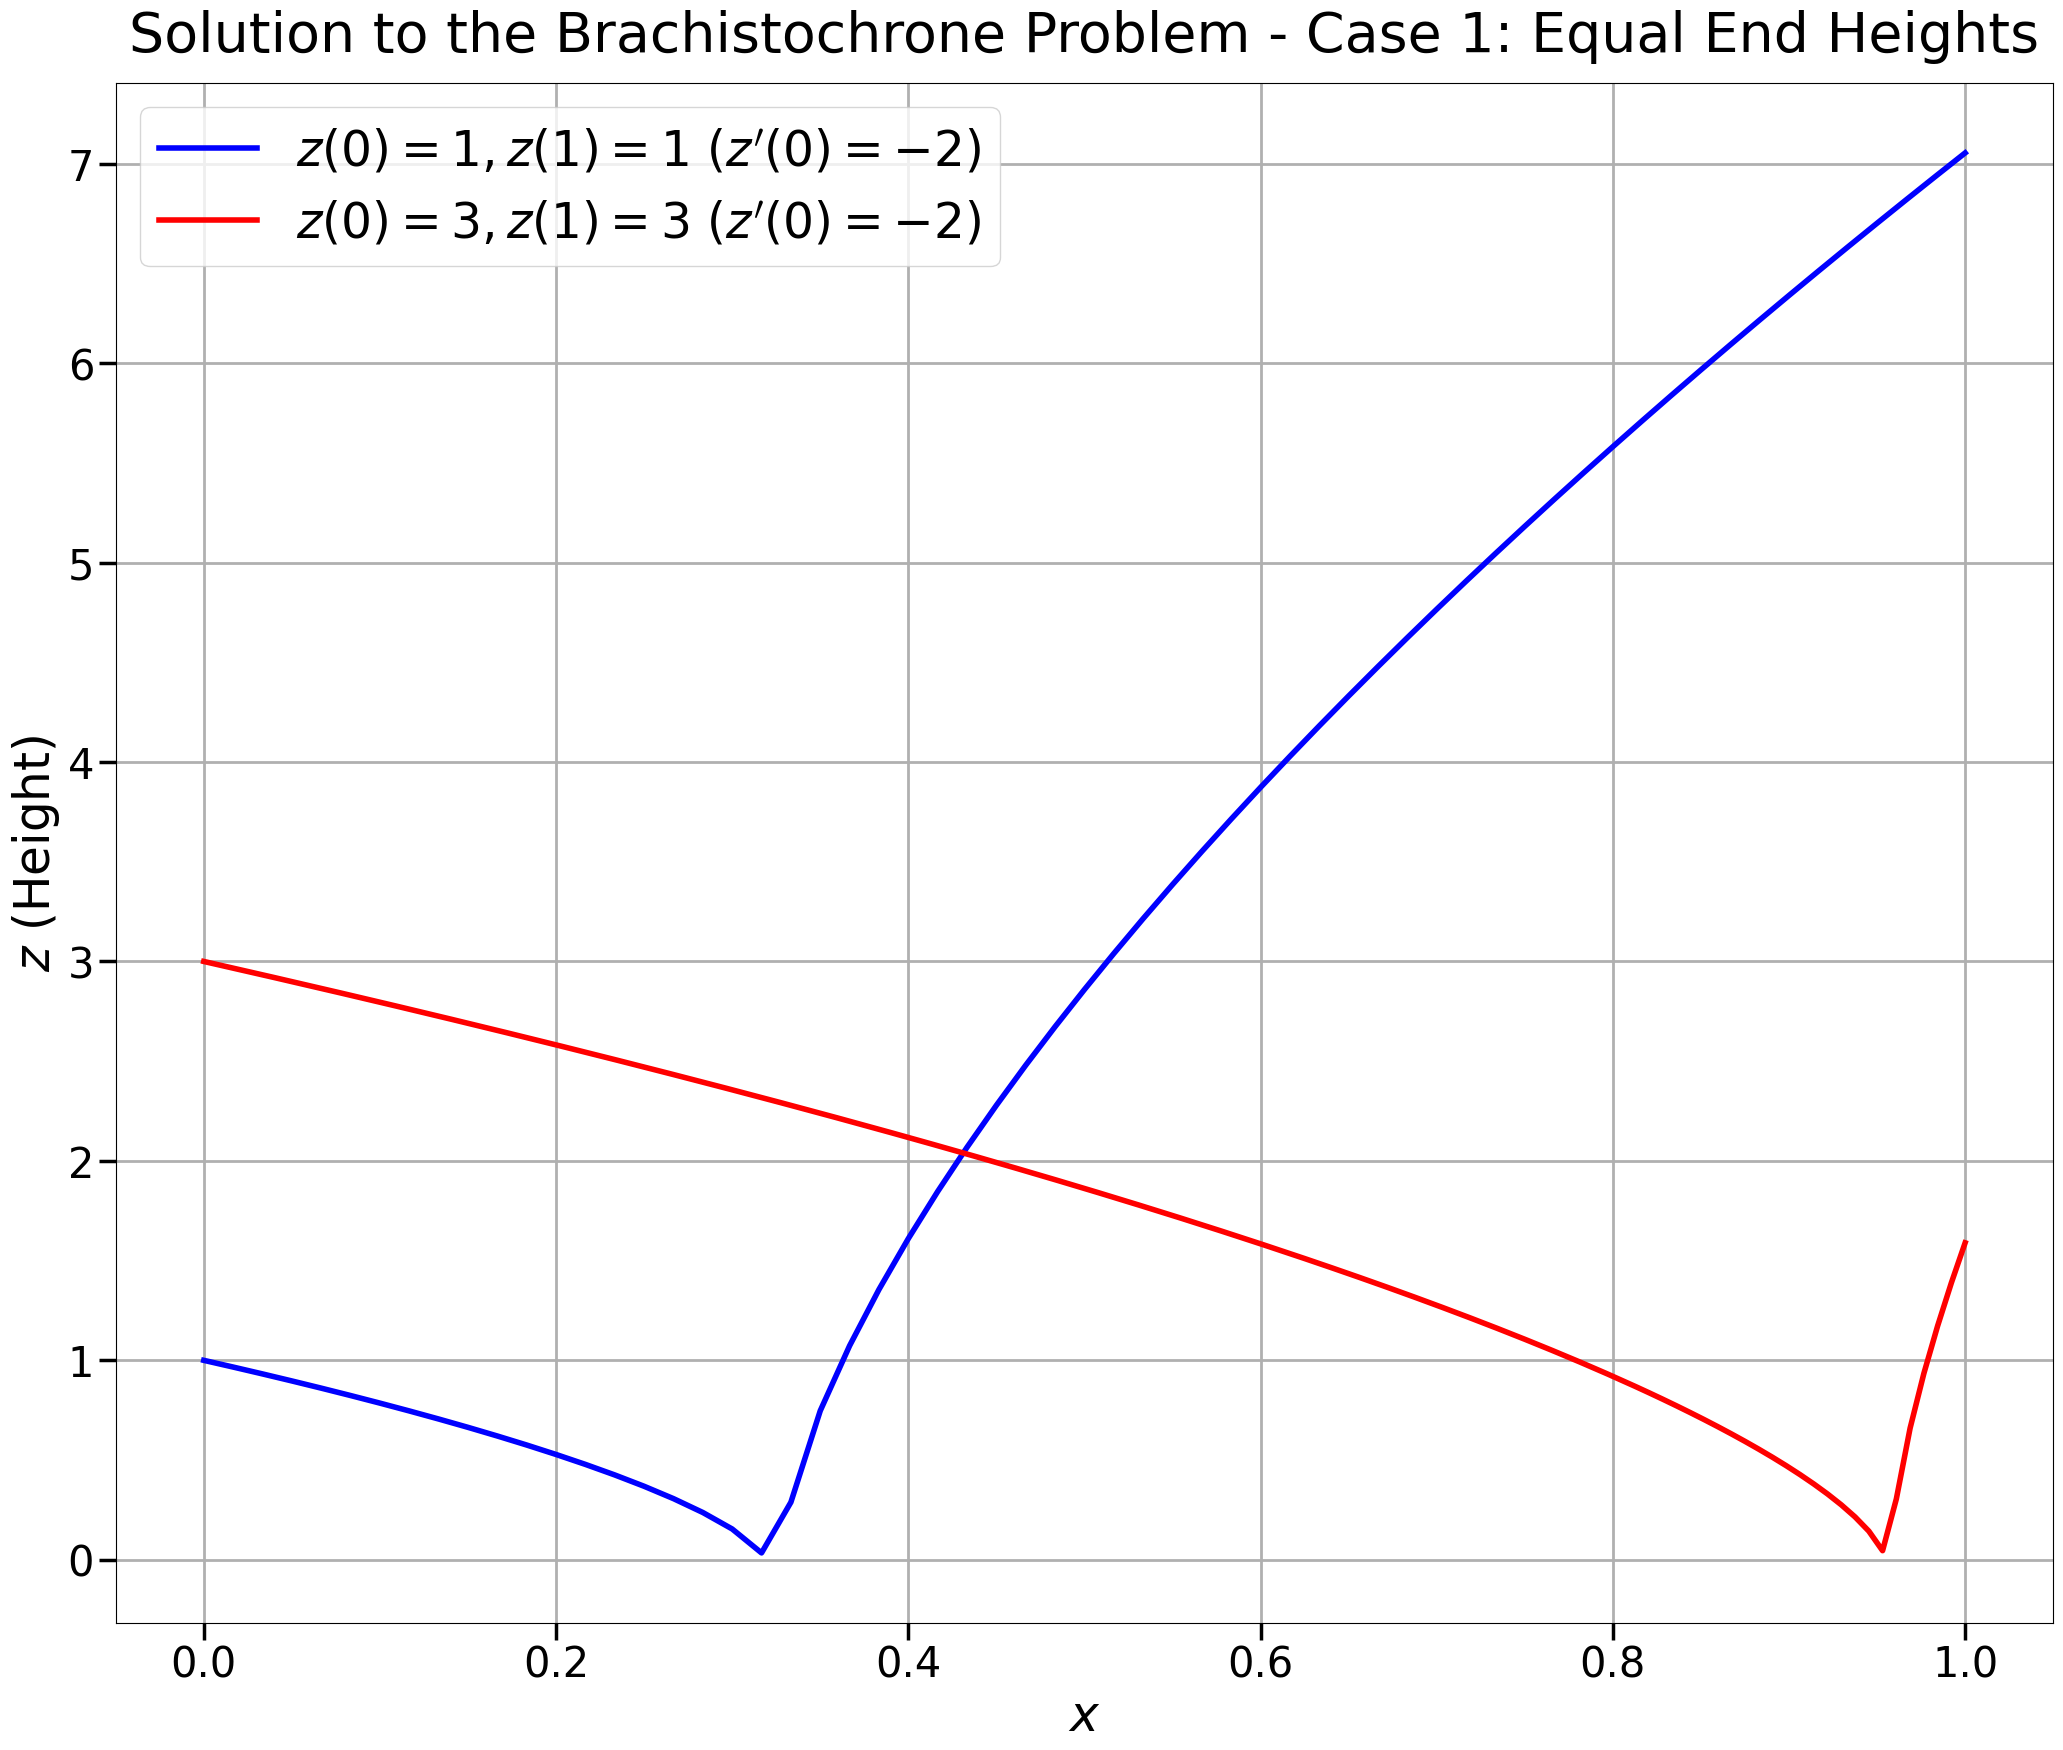

In [55]:
N_steps_1a = 60 # Step size for case 1a (Change as needed during shooting method)
N_steps_1b = 128 # Step size for case 1a (Change as needed during shooting method)

# Fixed choices for initial slopes
guess_1a = -2 # Guess for z(0)=1, z(1)=1
guess_1b = -2 # Guess for z(0)=3, z(1)=3

# Case 1a: z(0)=1, z(1)=1
x1a, z1a = shooting_method(1.0, 1.0, guess_1a, N_steps_1a)

# Case 1b: z(0)=3, z(1)=3
x1b, z1b = shooting_method(3.0, 3.0, guess_1b, N_steps_1b)
# # Check for shifted shape: Normalize x and z to see if they overlap
# z1b_normalized = z1b / 3.0 # Divide by initial height
# x_interp = np.linspace(0.0, 1.0, N_steps)
    
# # Use interpolation to compare shapes
# interp_1a = interp1d(x1a, z1a / 1.0)
# interp_1b = interp1d(x1b, z1b / 3.0)
    
# diff_case1 = np.max(np.abs(interp_1a(x_interp) - interp_1b(x_interp)))
# print(f"Max difference between normalized shapes (Case 1): {diff_case1:.2e}")

plt.plot(x1a, z1a, label=f'$z(0)=1, z(1)=1$ ($z\'(0)={guess_1a}$)', color='blue') # Plot for case 1a
plt.plot(x1b, z1b, label=f'$z(0)=3, z(1)=3$ ($z\'(0)={guess_1b}$)', color='red') # Plot for case 1b
plt.title('Solution to the Brachistochrone Problem - Case 1: Equal End Heights') # Title for the plot
plt.xlabel('$x$') # X-axis label
plt.ylabel('$z$ (Height)') # Y-axis label
plt.legend()
plt.grid(True)
plt.savefig("Plots/problem1_case1.png")
    
# plt.subplot(1, 2, 2)
# plt.plot(x_interp, interp_1a(x_interp), label='Case 1a Normalized', color='blue')
# plt.plot(x_interp, interp_1b(x_interp), label='Case 1b Normalized', color='red', linestyle='--')
# plt.title('Problem 1: Normalized Shapes Comparison (Same Height)')
# plt.xlabel('$x$')
# plt.ylabel('Normalized $z$ ($z/z_0$)')
# plt.legend()
# plt.grid(True)
# plt.savefig("Plots/problem1a.png")

### Case 2 - Left points at larger height

C:\Users\Owner\AppData\Local\Temp\ipykernel_8804\1381382201.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Calculated z_final: 6.001859960863742, Target z_end: 6.0
Shooting method converged.
Calculated z_final: 1.0004041867329305, Target z_end: 1.0
Shooting method converged.


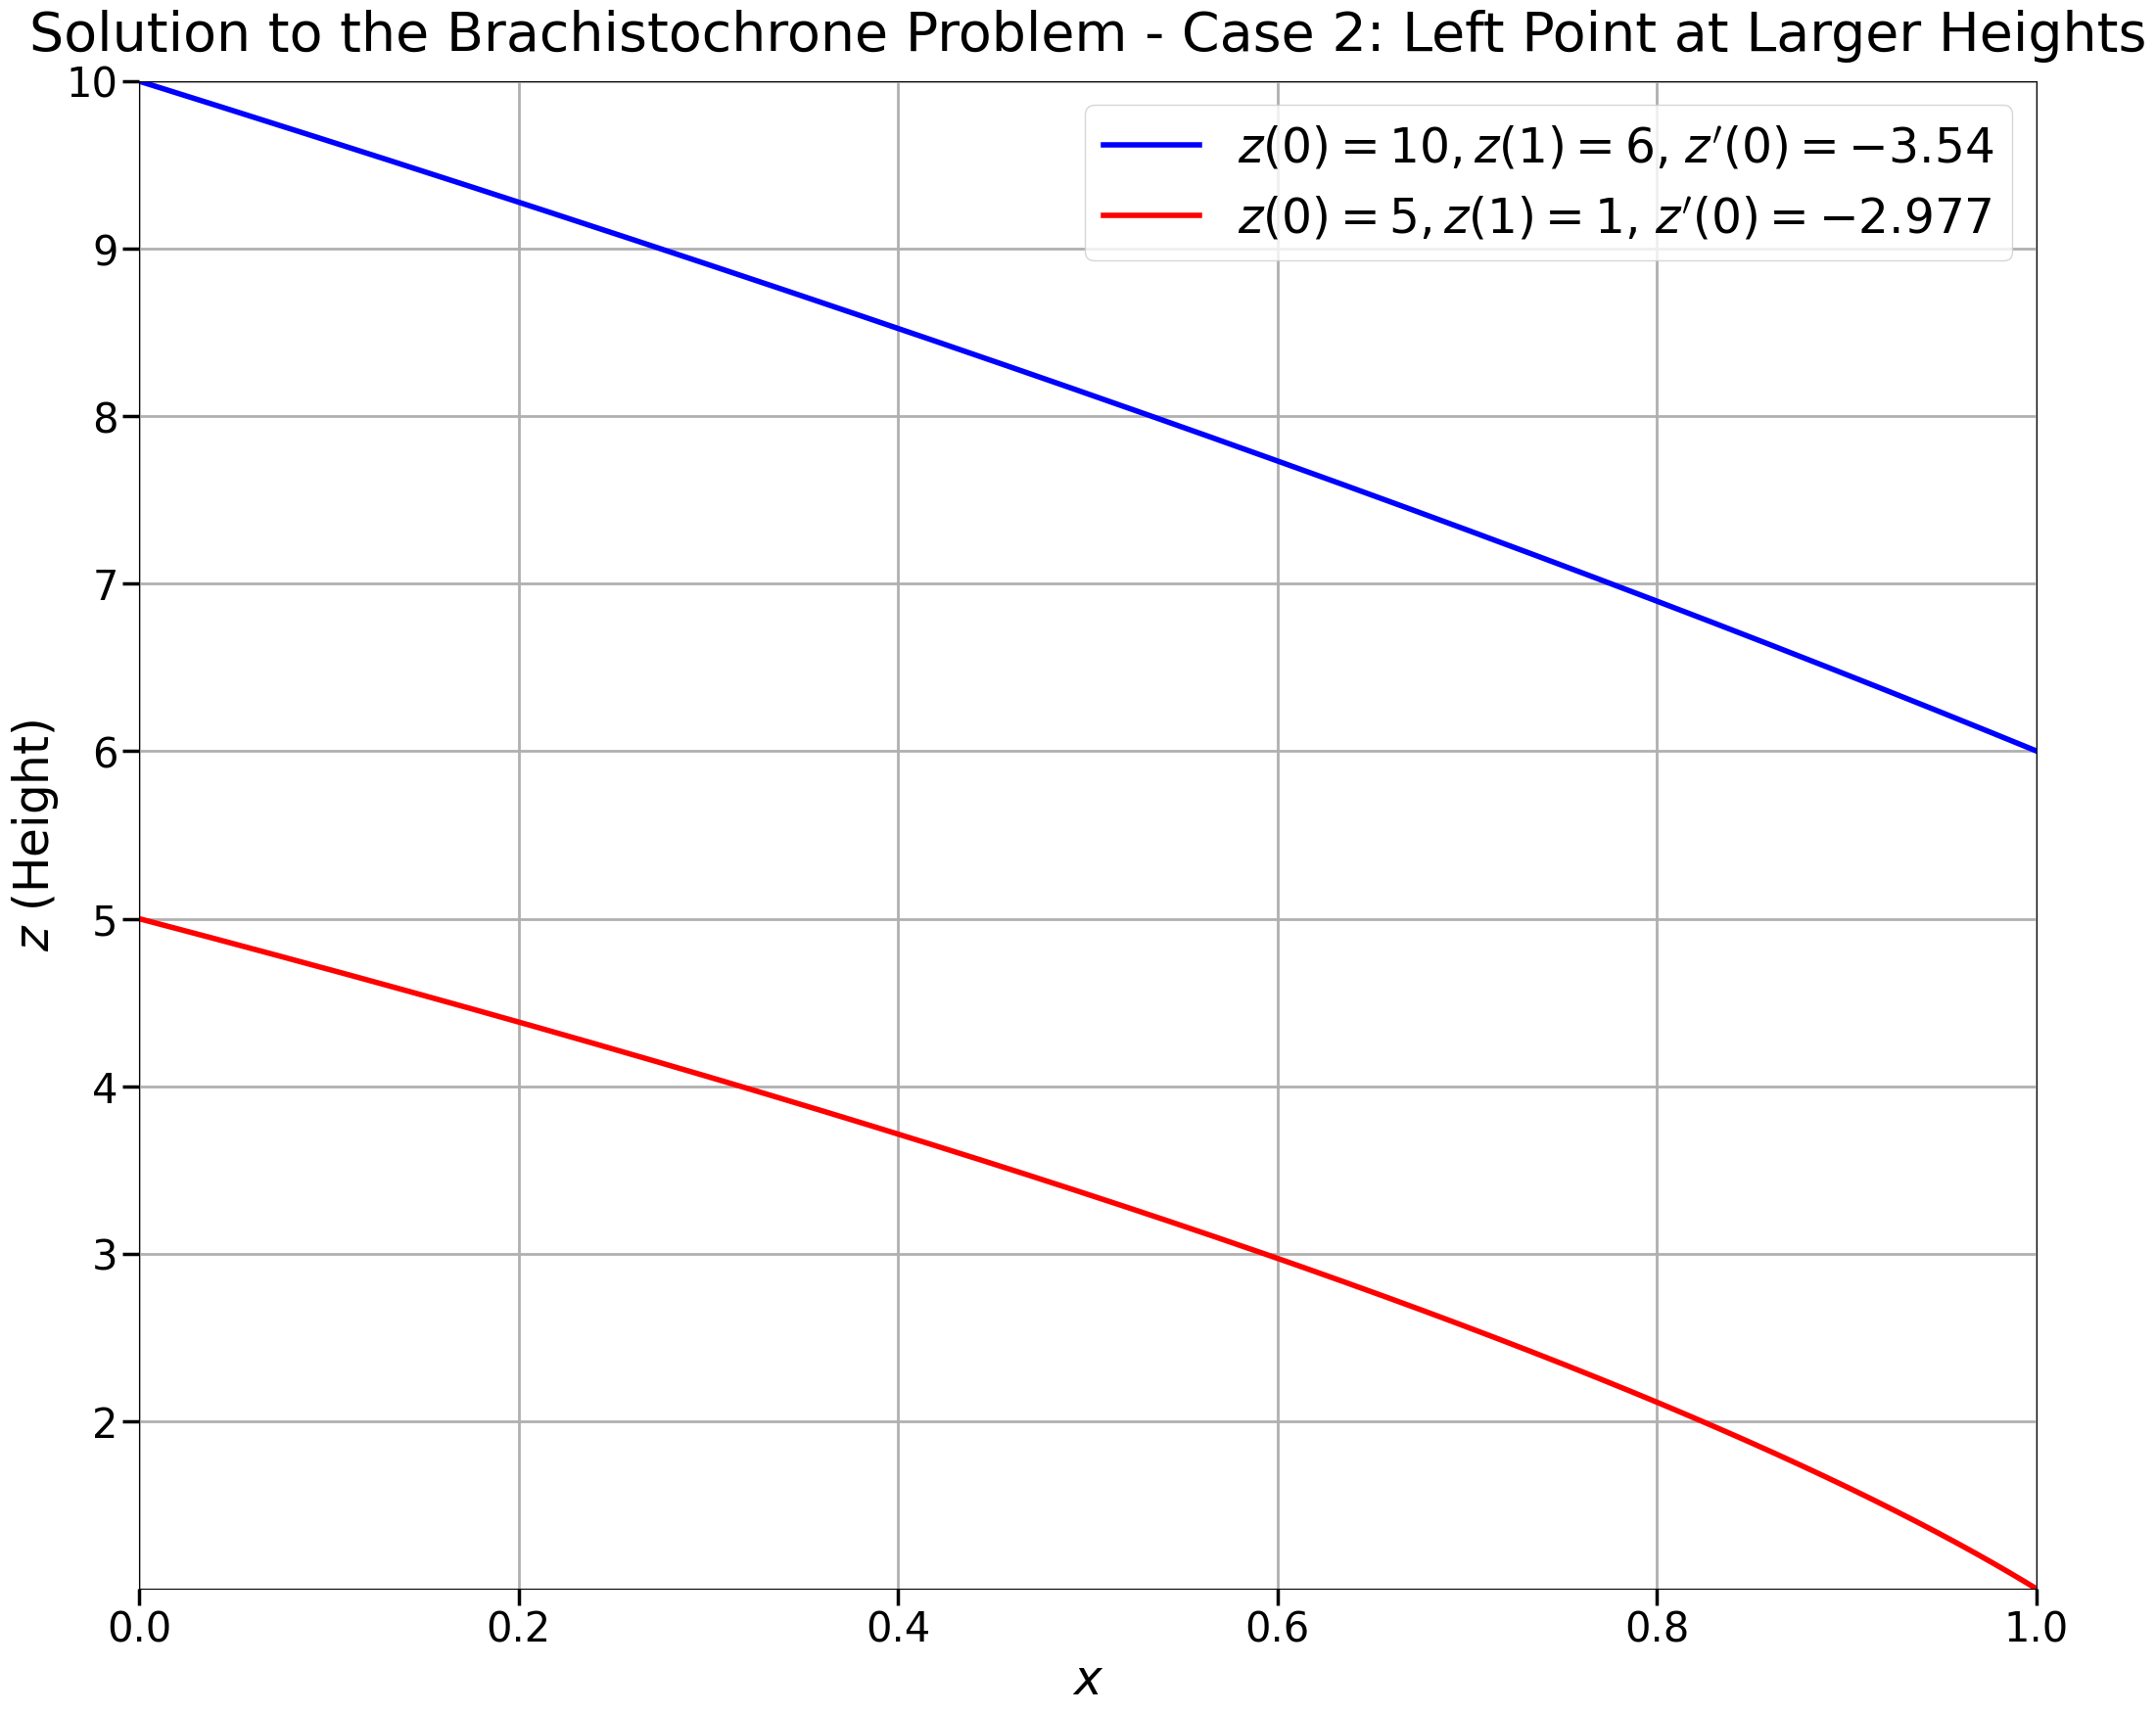

In [68]:
N_steps_2a = 1000 # Step size for case 1a (Change as needed during shooting method)
N_steps_2b = 1000 # Step size for case 1a (Change as needed during shooting method)

# Fixed choices for initial slopes
guess_2a = -3.54 # Guess for z(0)=10.0, z(1)=6.0
guess_2b = -2.977 # Guess for z(0)=5.0, z(1)=1.0

# Set up an empty plot
plt.title('Solution to the Brachistochrone Problem - Case 2: Left Point at Larger Heights') # Title
plt.xlabel('$x$') # X-axis label
plt.ylabel('$z$ (Height)') # Y-axis label
plt.legend()
plt.grid(True)

# Plot case 2a: z(0)=10, z(1)=6
x2a, z2a = shooting_method(10.0, 6.0, guess_2a, N_steps_2a)
plt.plot(x2a, z2a, label=f'$z(0)=10, z(1)=6$, $z\'(0)={guess_2a}$', color='blue') # Plot for case 2a

# Plot case 2b: z(0)=5, z(1)=1
x2b, z2b = shooting_method(5.0, 1.0, guess_2b, N_steps_2b)
plt.plot(x2b, z2b, label=f'$z(0)=5, z(1)=1$, $z\'(0)={guess_2b}$', color='red') # Plot for case 2b

plt.gca().set_xlim(x2a[0], x2a[-1]) # Set x-limits
plt.gca().set_ylim(z2b[-1], z2a[0]) # Set y-limits
plt.legend()
plt.savefig("Plots/problem1_case2.png")

# # Check for shifted shape: Normalize x and z to see if they overlap
# z1b_normalized = z1b / 3.0 # Divide by initial height
# x_interp = np.linspace(0.0, 1.0, N_steps)
    
# # Use interpolation to compare shapes
# interp_1a = interp1d(x1a, z1a / 1.0)
# interp_1b = interp1d(x1b, z1b / 3.0)
    
# diff_case1 = np.max(np.abs(interp_1a(x_interp) - interp_1b(x_interp)))
# print(f"Max difference between normalized shapes (Case 1): {diff_case1:.2e}")
    
# plt.subplot(1, 2, 2)
# plt.plot(x_interp, interp_1a(x_interp), label='Case 1a Normalized', color='blue')
# plt.plot(x_interp, interp_1b(x_interp), label='Case 1b Normalized', color='red', linestyle='--')
# plt.title('Problem 1: Normalized Shapes Comparison (Same Height)')
# plt.xlabel('$x$')
# plt.ylabel('Normalized $z$ ($z/z_0$)')
# plt.legend()
# plt.grid(True)
# plt.savefig("Plots/problem1a.png")

### Case 3 - Right points at larger height

Calculated z_final: 10.004406085254058, Target z_end: 10.0
Calculated z_final: 6.001859960863742, Target z_end: 6.0


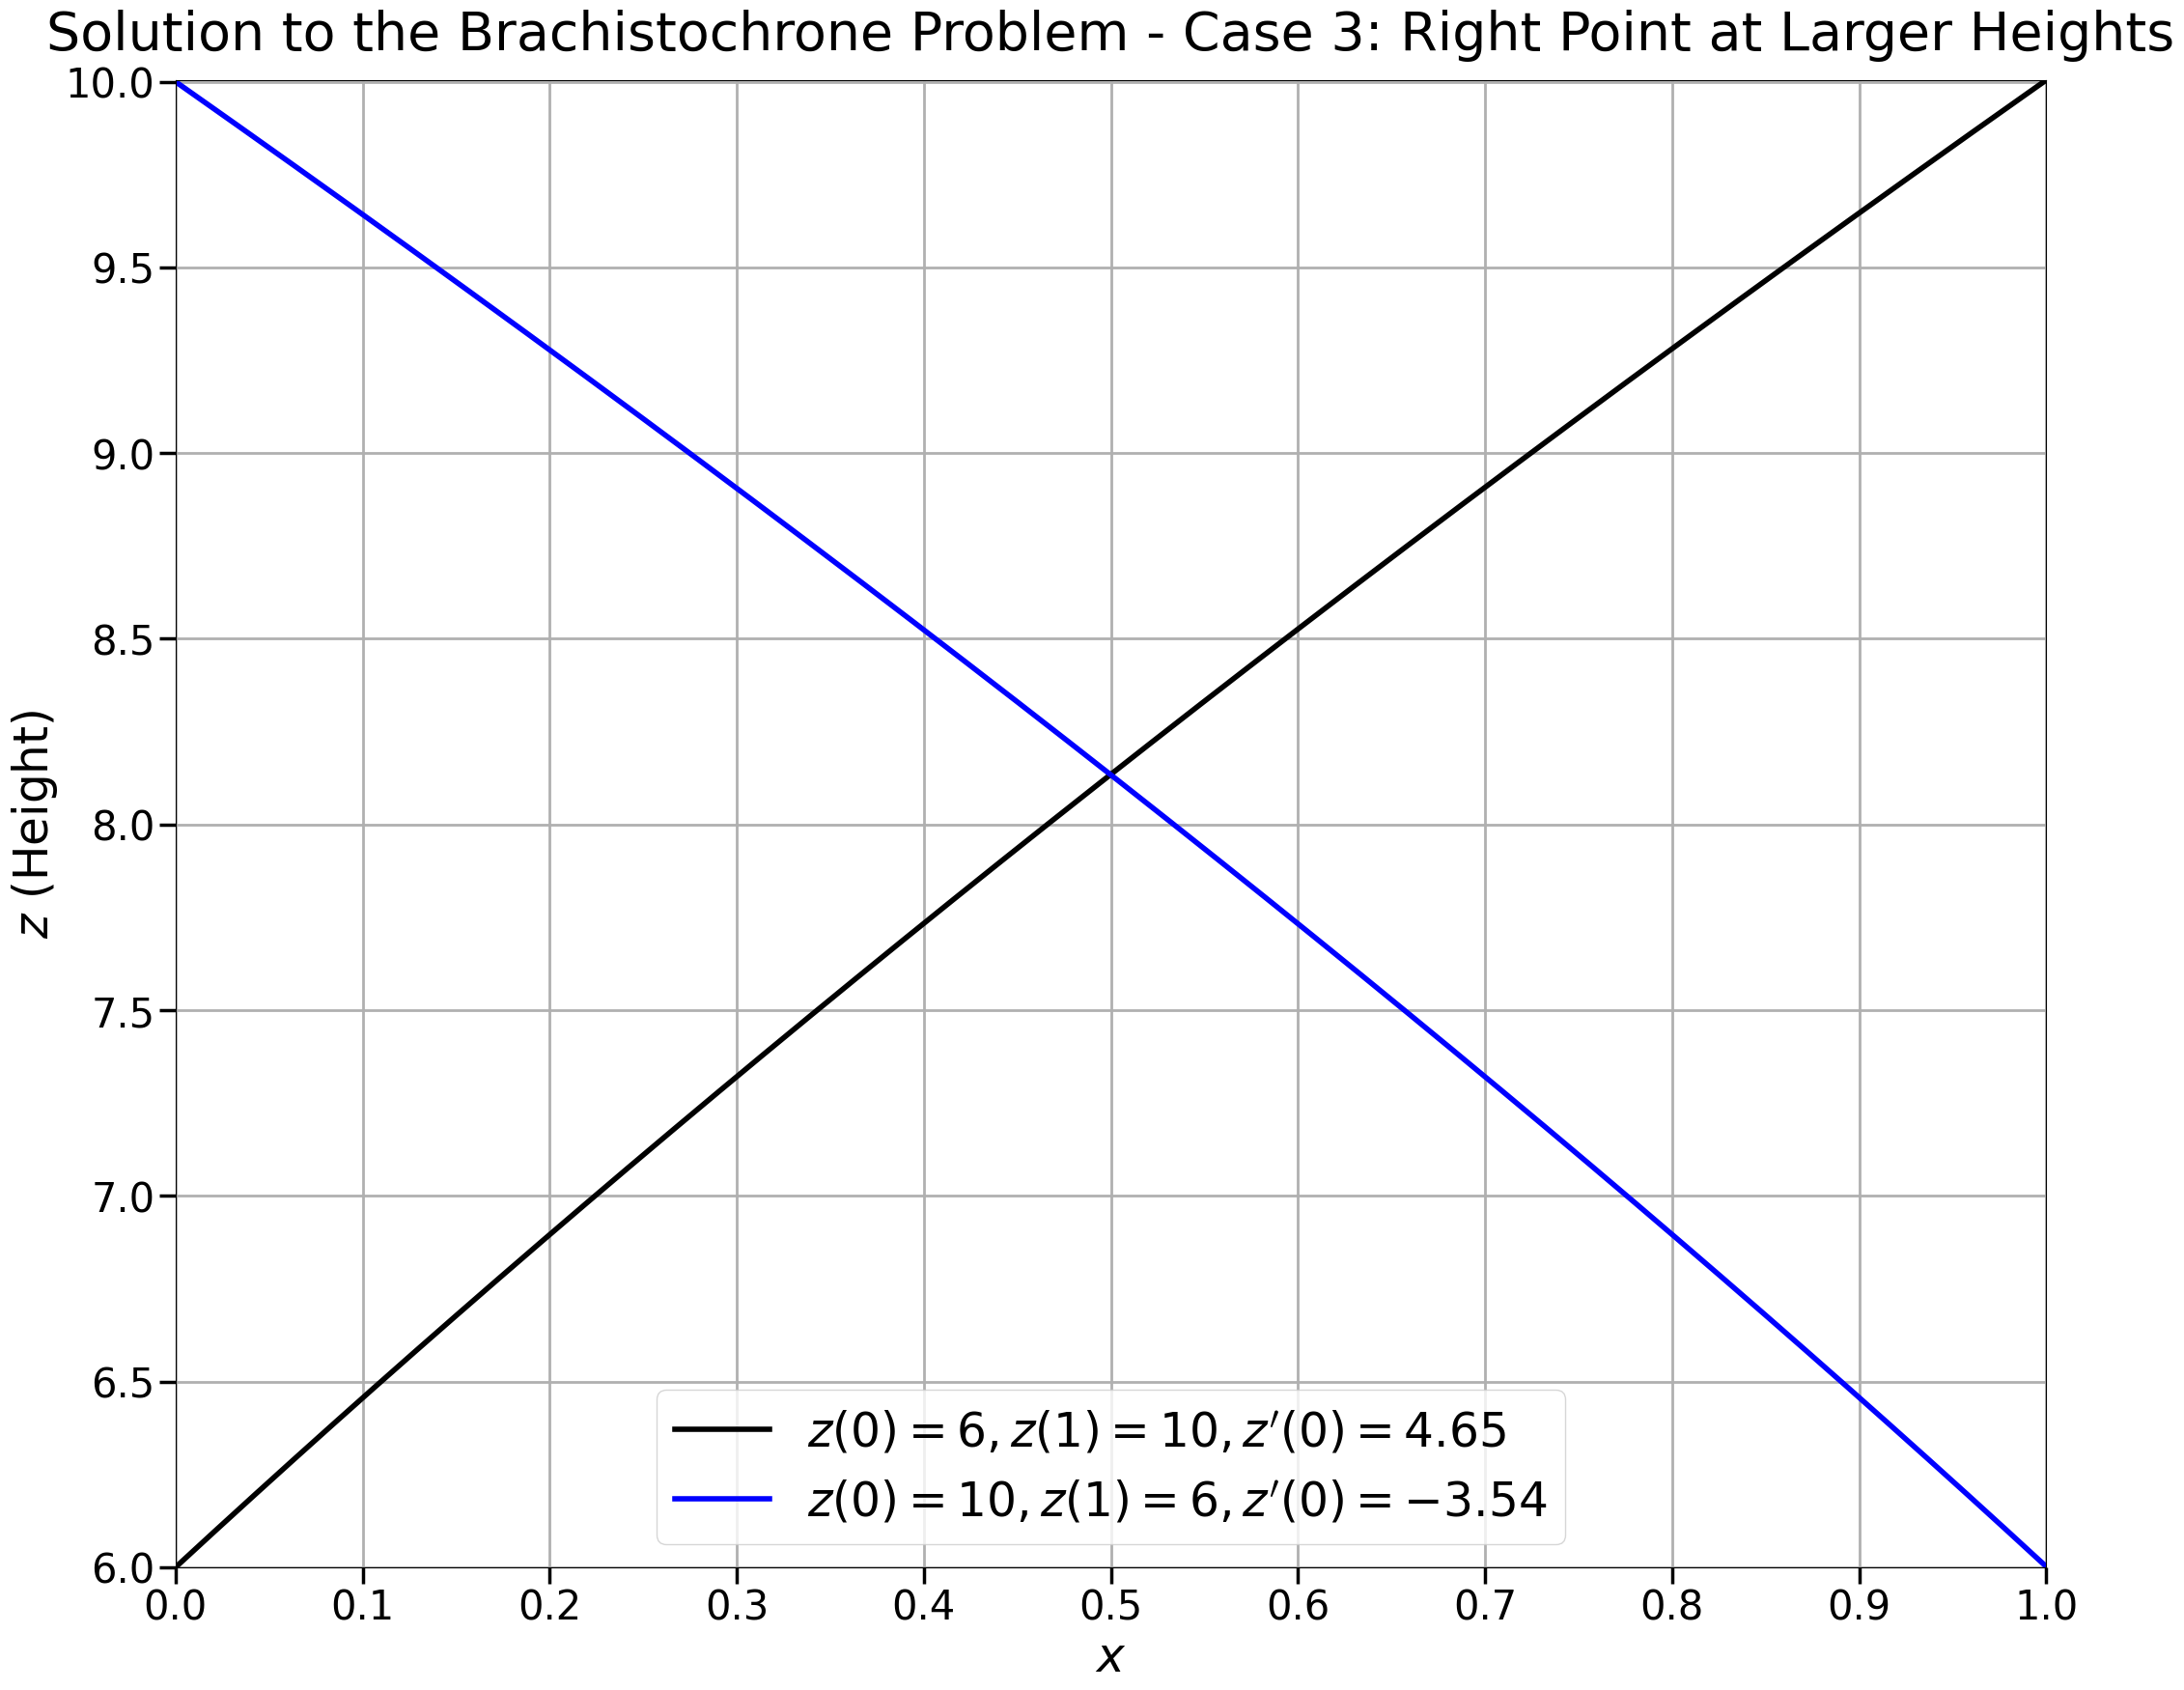

In [57]:
N_steps_3 = 1000 # Step size for case 1a (Change as needed during shooting method)

# Fixed choice(s) for initial slope(s)
guess_3a = 4.65 ## Guess for z(0)=6.0, z(1)=10.0
guess_3b = -3.54 ## Guess for z(0)=10.0, z(1)=6.0

# Set up an empty plot
plt.title('Solution to the Brachistochrone Problem - Case 3: Right Point at Larger Heights') # Title
plt.xlabel('$x$') # X-axis label
plt.ylabel('$z$ (Height)') # Y-axis label

# Plot case 3a: z(0)=6.0, z(1)=10.0
x3a, z3a = shooting_method(6.0, 10.0, guess_3a, N_steps_3)
plt.plot(x3a, z3a, label=f'$z(0)=6, z(1)=10, z\'(0)={guess_3a}$', color='black')

# Plot case 3b: z(0)=10.0, z(1)=6.0
x3b, z3b = shooting_method(10.0, 6.0, guess_3b, N_steps_3)
plt.plot(x3b, z3b, label=f'$z(0)=10, z(1)=6, z\'(0)={guess_3b}$', color='blue')

plt.gca().set_xlim(x3a[0], x3a[-1]) # Set x-limits
plt.gca().set_ylim(z3a[0], z3a[-1]) # Set y-limits
plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.grid(True)
plt.savefig("Plots/problem1_case3.png")

# # Check for shifted shape: Normalize x and z to see if they overlap
# z1b_normalized = z1b / 3.0 # Divide by initial height
# x_interp = np.linspace(0.0, 1.0, N_steps)
    
# # Use interpolation to compare shapes
# interp_1a = interp1d(x1a, z1a / 1.0)
# interp_1b = interp1d(x1b, z1b / 3.0)
    
# diff_case1 = np.max(np.abs(interp_1a(x_interp) - interp_1b(x_interp)))
# print(f"Max difference between normalized shapes (Case 1): {diff_case1:.2e}")

# plt.subplot(1, 2, 2)
# plt.plot(x_interp, interp_1a(x_interp), label='Case 1a Normalized', color='blue')
# plt.plot(x_interp, interp_1b(x_interp), label='Case 1b Normalized', color='red', linestyle='--')
# plt.title('Problem 1: Normalized Shapes Comparison (Same Height)')
# plt.xlabel('$x$')
# plt.ylabel('Normalized $z$ ($z/z_0$)')
# plt.legend()
# plt.grid(True)
# plt.savefig("Plots/problem1a.png")

# **Part 2: Convergence Testing with $\delta C$ at x=1**

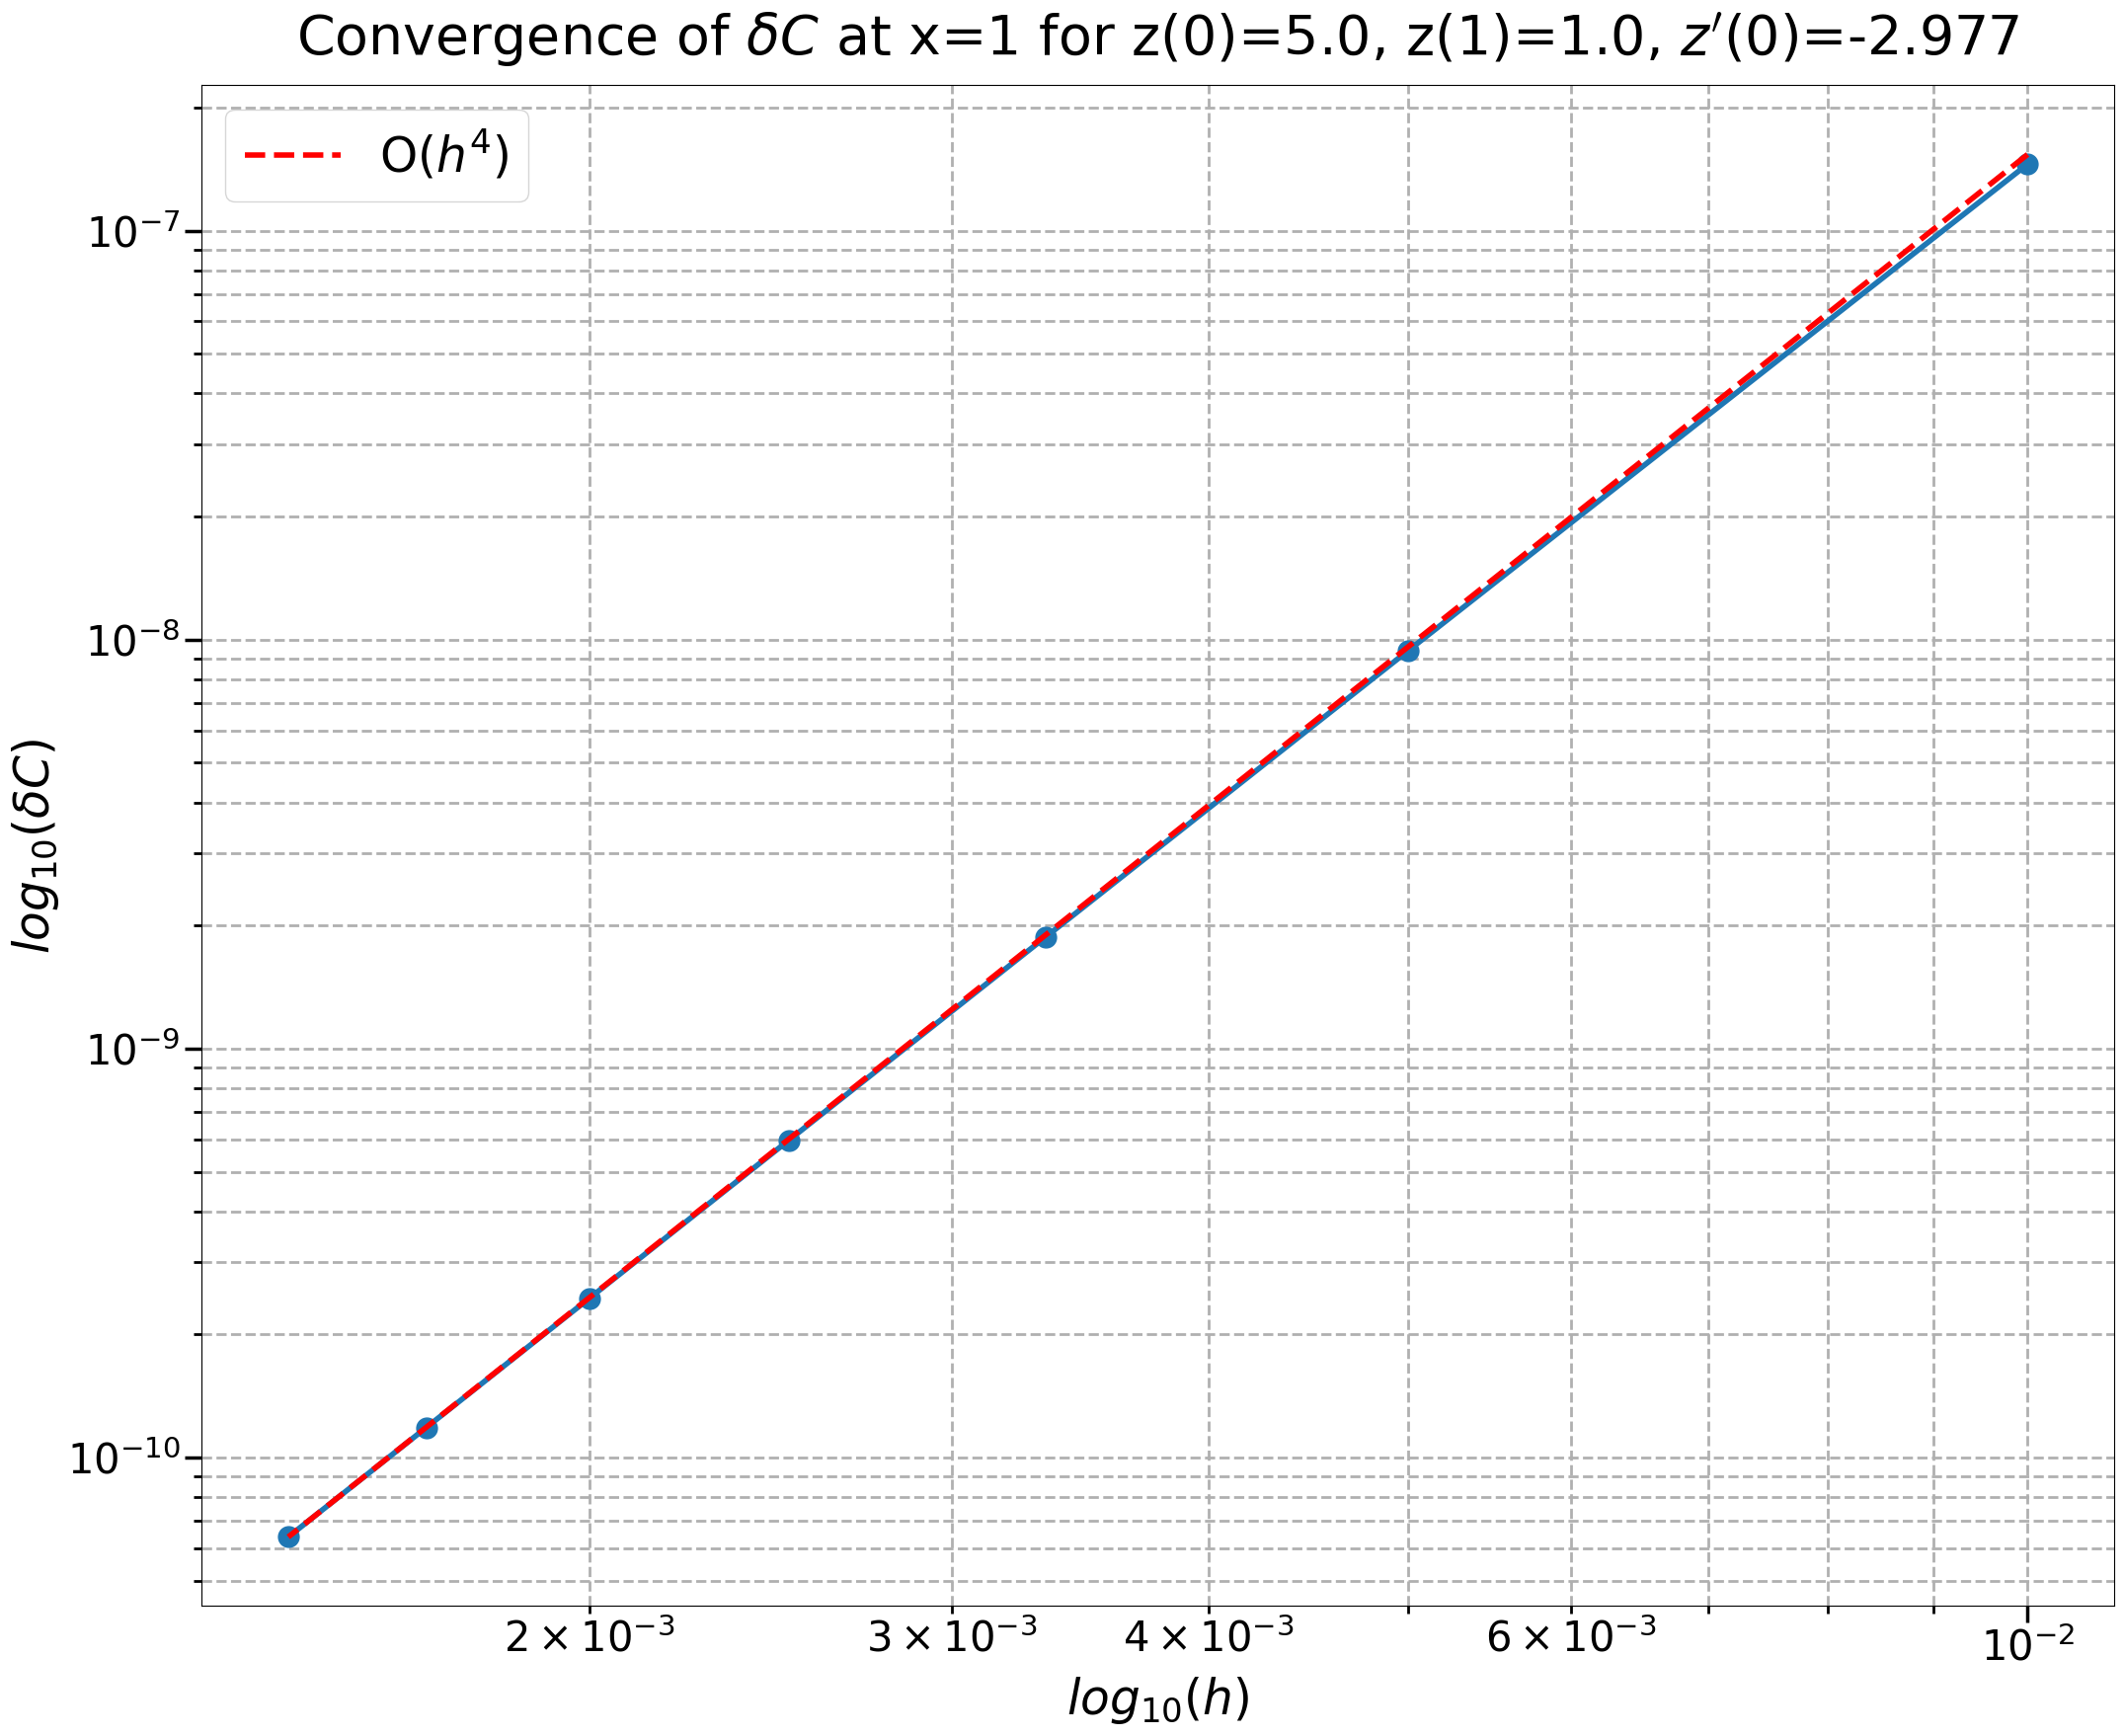

In [ ]:
# Use z(0)=5, z(1)=1, and z'(0)=-2 for convergence test
z_start = 5.0
z_end = 1.0
dzdx_start = -2.977
init_conditions = np.array([z_start, dzdx_start])

# N_values = 2**np.arange(3, 12) # Array of N-values for convergence testing: N = 8, 16, 32, ..., 2048
# h_values = 1.0 / N_values # Corresponding step sizes (h = (b-a)/N with a=0, b=1)

# Empty arrays to store values
h_values = [] ## Step sizes
delta_C_values = [] ## Delta C values

# Loop over N = 100, 200,... 700 to compute delta_C for each
for N in range (100, 800, 100):
    h = 1.0 / N
    h_values.append(h)
    
    ## Compute values of z and dz/dx with RK4 integration
    _, u_history = rk4_interpolation(system_of_odes, 0.0, 1.0, N, init_conditions)
    z_solution = u_history[:,0]
    zprime_solution = u_history[:,1]
    
    ## Calculate \delta C at x=1
    C_initial = integral_of_motion(z_solution[0], zprime_solution[0]) ## Initial integral of motion at x=0
    C_final = integral_of_motion(z_solution[-1], zprime_solution[-1]) ## Final integral of motion at x=1
    delta_C = np.abs((C_final-C_initial)/(C_initial))
    
    ## Add to list of delta_C values
    delta_C_values.append(delta_C)
delta_C_values = np.array(delta_C_values)

# Set up the log-log plot for convergence analysis
plt.title(fr"Convergence of $\delta C$ at x=1 for z(0)={z_start}, z(1)={z_end}, $z'(0)$={dzdx_start}")
plt.xlabel(r'$log_{10}(h)$')
plt.ylabel(r'$log_{10}(\delta C)$')
plt.grid(True, which="both", ls="--")

# Plot the \delta C values against h-values on a log-log scale
plt.loglog(h_values, delta_C_values, marker='o', linestyle='-')

# Plot the reference line for fourth-order convergence
plt.loglog(h_values, delta_C_values[-1]*(np.array(h_values)/h_values[-1])**(4), linestyle='--', color='red', label=r'O($h^4$)')

plt.legend()
plt.savefig("Plots/problem2.png")

# **Part 3: Self-convergence of Solution for z(1)**

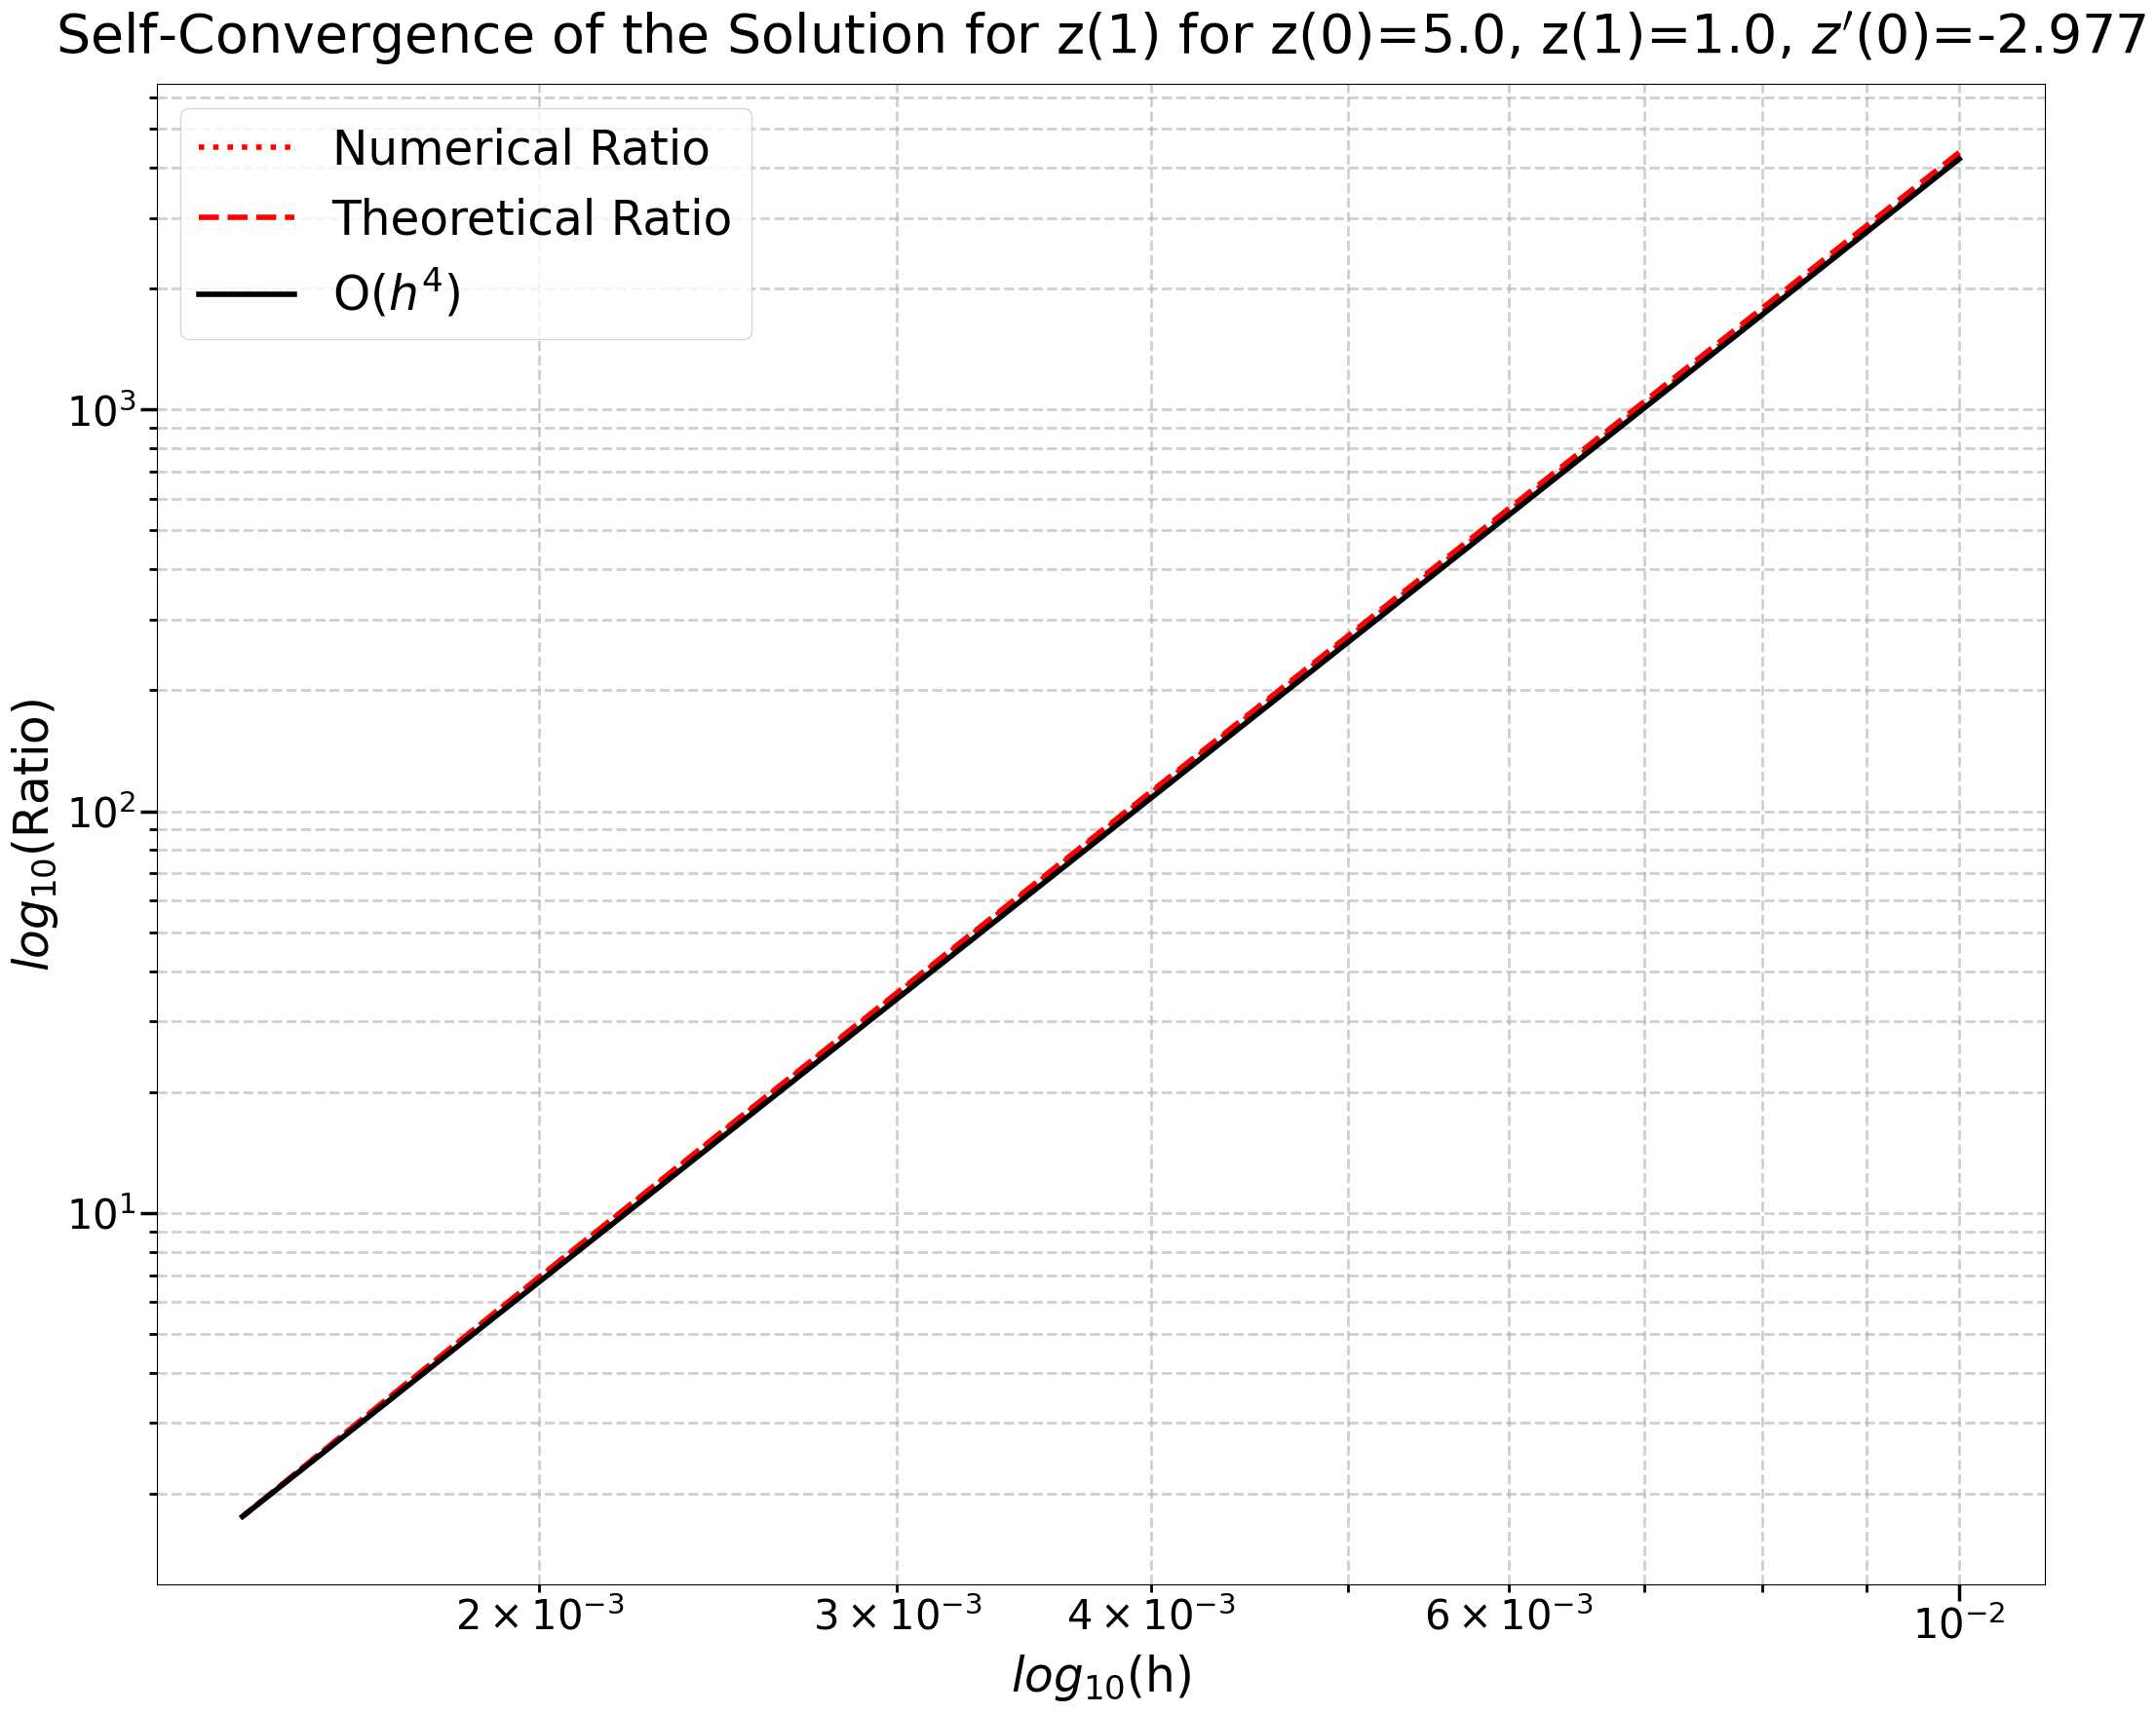

In [ ]:
# Use z(0)=5, z(1)=1, and z'(0)=-2 for self-convergence test
z_start = 5.0
z_end = 1.0
dzdx_start = -2.977
init_conditions = np.array([z_start, dzdx_start])

# Define the reference resolutions h2 (N = 800) and h3 (N = 1600)
h2 = 1.0/800.0
h3 = 1.0/1600.0

# Set up an empty plot
plt.xlabel("$log_{10}$"+"(h)") # X-axis label
plt.ylabel("$log_{10}$"+"(Ratio)",x=-0.01) # Y-axis label
plt.title(fr"Self-Convergence of the Solution for z(1) for z(0)={z_start}, z(1)={z_end}, $z'(0)$={dzdx_start}")
plt.grid(True, which="both", ls="--", alpha=0.6)

# Empty arrays to store values for plotting
h_values = [] ## h-values
numerical_ratios = [] ## Numerical ratios
theoretical_ratios = [] ## Theoretical ratios

# Loop over N = 100,200,...,700 to compute ratios for self-convergence with RK4
for N in range(100, 800, 100):    
    ## Compute the solution for z at x = 1 with current resolution N
    h = 1.0 / N
    h_values.append(h)
    _, u_history_N = rk4_interpolation(system_of_odes, 0.0, 1.0, N, init_conditions)
    z_solution = u_history_N[:,0]
    z_h = z_solution[-1]
    
    ## Compute the solution for z at x = 1 with resolution h2 (N=800)
    _, u_history_h2 = rk4_interpolation(system_of_odes, 0.0, 1.0, 800, init_conditions)
    z_solution_h2 = u_history_h2[:,0]
    z_h2 = z_solution_h2[-1]
    
    ## Compute the solution for z at x = 1 with resolution h3 (N=1600)
    _, u_history_h3 = rk4_interpolation(system_of_odes, 0.0, 1.0, 1600, init_conditions)
    z_solution_h3 = u_history_h3[:,0]
    z_h3 = z_solution_h3[-1]
    
    ## Compute the numerical ratio
    r_numerical = (z_h-z_h3)/(z_h2-z_h3)
    numerical_ratios.append(r_numerical)
    
    ## Compute the theoeretical ratio for 4th-order convergence
    r_theoretical = (((h/h3)**4)-1)/((2**4)-1)
    theoretical_ratios.append(r_theoretical)

    #print(z_h, z_h2, z_h3, r_numerical, r_theoretical)
#print(h_values)

# Plot the numerical and theoretical ratios vs h-values on a log-log scale
plt.loglog(h_values,numerical_ratios,color="red",linestyle="dotted",label="Numerical Ratio")
plt.loglog(h_values,theoretical_ratios,color="red",linestyle="dashed",label="Theoretical Ratio")

# Plot the reference line for fourth-order convergence
plt.loglog(h_values, theoretical_ratios[-1]*(np.array(h_values)/h_values[-1])**4, color="black", linestyle='solid', label=r'O($h^4$)')

plt.legend()
plt.savefig("Plots/problem3.png") 

# **Part 4: Error of z(0.9) using Richardson extrapolation**

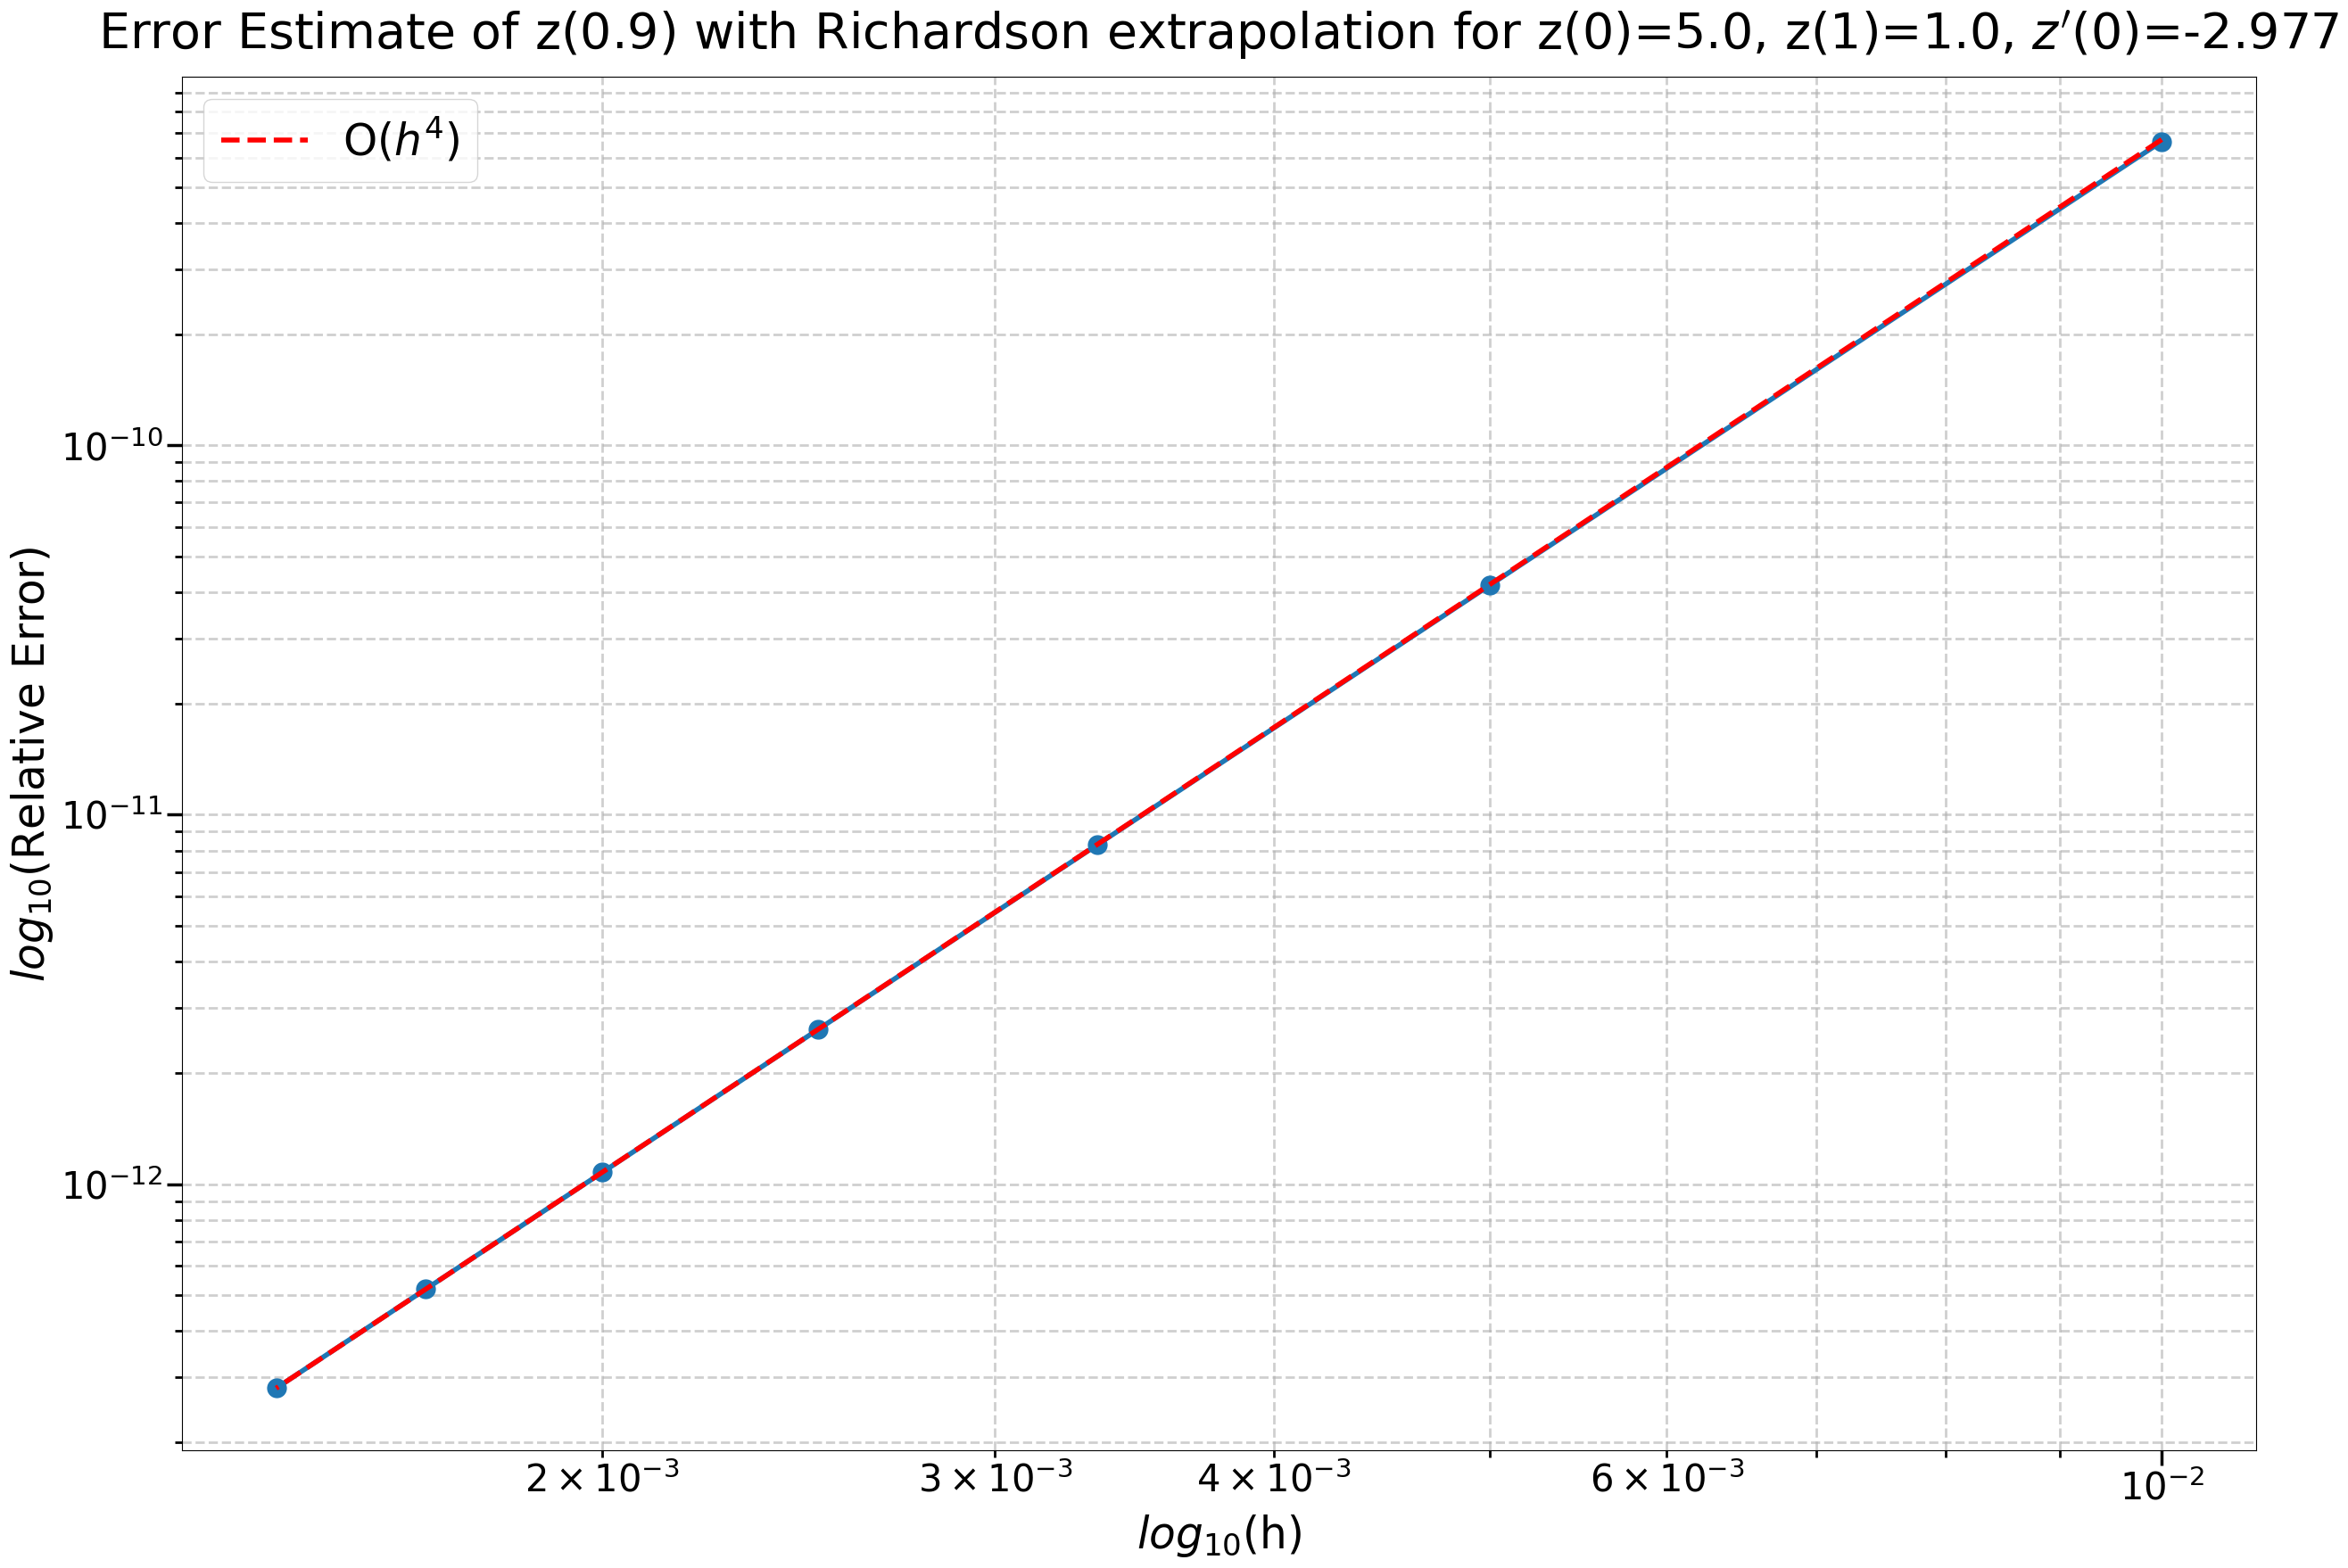

In [ ]:
# Use the same initial conditions as in Parts 2 & 3
z_start = 5.0
z_end = 1.0
dzdx_start = -2.977
init_conditions = np.array([z_start, dzdx_start])

x_target = 0.9 # Target x-value for Richardson extrapolation

# Define the reference resolutions h2 (N = 800) and h3 (N = 1600)
h2 = 1.0/800.0
h3 = 1.0/1600.0

# Set up an empty plot
plt.figure(figsize=(30,20))
plt.xlabel("$log_{10}$"+"(h)") # X-axis label
plt.ylabel("$log_{10}$"+"(Relative Error)",x=-0.01) # Y-axis label
plt.title(fr"Error Estimate of z(0.9) with Richardson extrapolation for z(0)={z_start}, z(1)={z_end}, $z'(0)$={dzdx_start}")
plt.grid(True, which="both", ls="--", alpha=0.6)

# Empty arrays to store values for plotting
h_values = [] ## h-values
richardson_error = [] ## Error from Richardson extrapolation

# Loop over N = 100,200,...,700 to implement Richardson extrapolation
for N in range (100,800,100):
    # Compute h-value for plotting
    h = 1.0/N
    h_values.append(h)
    
    # Define two step sizes h and h/2 for the extrapolation
    N_h = N
    N_h2 = N_h*2

    # Solution z(x_target) with step size h
    x_h, u_history_h = rk4_interpolation(system_of_odes, 0.0, 1.0, N_h, init_conditions)
    z_h_interpolated = CubicHermiteSpline(x_h, u_history_h[:,0],u_history_h[:,1]) ## Perform Lagrange interpolation
    z_h_target = z_h_interpolated(x_target) ## Solution z(x_target) with step size h

    # Solution z(x_target) with step size h/2
    x_h2, u_history_h2 = rk4_interpolation(system_of_odes, 0.0, 1.0, N_h2, init_conditions)
    z_h2_interpolated = CubicHermiteSpline(x_h2, u_history_h2[:,0], u_history_h2[:,1]) ## Perform Lagrange interpolation
    z_h2_target = z_h2_interpolated(x_target) ## Solution z(x_target) with step size h
    
    # Estimate the error (p = 4 for RK4)
    # z_ext = (1/(2**4)-1)*(16*z_h2_target-z_h_target) ## Compute the extrapolated value of the solution
    estimated_error = np.abs((z_h2_target-z_h_target)/(15)) ## Estimate the error
    richardson_error.append(estimated_error)

# Plot the Richardson estimated errors vs h-values on a log-log scale
plt.loglog(h_values,richardson_error,marker='o', linestyle='-')

# Plot the reference line for fourth-order convergence (O(h^(p+1)))
plt.loglog(h_values,richardson_error[-1]*(np.array(h_values)/h_values[-1])**(4), linestyle='--', color='red', label=r'O($h^4$)')

plt.legend()
plt.savefig("Plots/problem4.png")